In [1513]:
import h5py    
from scipy.ndimage.filters import gaussian_filter1d
from scipy.ndimage.filters import uniform_filter
from scipy.interpolate import interp1d
from IPython.display import clear_output
import multiprocessing as mp
## Make sure plots are create inline
%matplotlib inline
## The usual packages (numpy, matplotlib, etc)
from RSE_style import *
# figsize(10,8)



In [684]:
import h5py as h5
l1 = h5.File('./data/CFIS_L1_NGDCS20170619t184335_cal_2018_v2.h5','r')
spectra_ = np.array(l1['camera/radiances'][:])
wlSize=2048
disp = np.asarray([-1.2553e-6,0.0201,735.4572])
ind = np.linspace(1,wlSize,wlSize)
wlGrid_ = np.polyval(disp,ind )
wlGrid = wlGrid_[(wlGrid_>747)&(wlGrid_<756)]
spectra_ = spectra_[:,(wlGrid_>747)&(wlGrid_<756),:]
l1.close()



In [685]:
# Read in tabulated pre-computed dataset.
sun = np.loadtxt('data/solar_merged_20160127_600_26316_100.out')
# interpolate to common grid in wavelength (not wavenumber), use 0.002nm sampling here
res = 0.002
# create wavelength grid in nm
wl = np.arange(727,776,res)
# Solar transmission spectrum, resample to wavelength grid (from wavenumber):
f = interp1d(1.e7/sun[:,0], sun[:,1])
Tsun = f(wl)
co = 2.355
T_cfis = gaussian_filter1d(Tsun, 0.07/res/co)




In [686]:
wl.shape

(24500,)

In [687]:
SIF_shape.shape

(501,)

In [688]:
f1 = h5py.File('./data/PS_SIF_map_easy.h5','r')    
f1_keys=list(f1.keys())
list(f1.keys())
SIF_shape_ = f1['SIF_shape'][:] # (437,)

wl_sif = f1['wlGrid'][:] # dwlGrid = 0.03 (437,)
f = interp1d(wl_sif,SIF_shape_,fill_value="extrapolate")
SIF_shape = f(wlGrid)
f1.close()

In [689]:
co = 2.355


class Setup:
    pass
mySetup = Setup()

mySetup.FWHM = 0.07
# wo = np.where((wl_solarSpectrum>743)&(wl_solarSpectrum<757))[0]
# mySetup.wl_so = wl

mySetup.wl_in = wl
mySetup.wl_out = wlGrid
mySetup.res = 0.01 # wlGrid[1:]-wlGrid[0:-1]




In [690]:
# reference solar spectrum
# Lo = Tsun*s_base/np.pi # mW/M2/SR/UM
Tsun = T_cfis.copy()
Lo = Tsun/np.pi 

In [ ]:

# def forward_model_shift(x,b,compK = False):
#     poly_wl = x[0:3]
#     b.FWHM = x[3]
#     poly = x[-4:-1]

#     a = x[-1]
# #     c1 = x[0]; p0 = x[1]; p1 = x[2]; p2 = x[3]; a = x[4]
    

#     Lo_conv = gaussian_filter1d(Lo,b.FWHM/b.res/co)
    
#     detPixels = len(b.wl_in)
#     grid = np.arange(0,detPixels,1)-detPixels/2.
# #     wl_shifted = grid+c1 # b.nu_out in the example 8
#     wl_shifted = np.polyval(poly_wl,grid)
    
#     finter1 = interp1d(grid, Lo_conv,kind='linear', fill_value=np.NaN,bounds_error=False)
#     Lo_conv_shifted = finter1(wl_shifted)
    
#     finter2 = interp1d(b.wl_in, Lo_conv_shifted,kind='linear', fill_value=np.NaN,bounds_error=False)
#     Lo_1 = finter2(b.wl_out)# output Lo
    
#     dwl = b.wl_out-np.mean(b.wl_out)
#     F_ref_nosif = Lo_1*np.polyval(poly,dwl)
#     F_forward = F_ref_nosif+a*SIF_shape

#     if compK:
#         K = np.zeros((len(b.wl_out),len(x)))
# #         dx = [5e-6,5e-6,5e-6]
#         dx = [1e-6,1e-6,1e-6,1e-6]
#         for i in range(3):
#             poly_wl2 = poly_wl.copy()
#             poly_wl2[i] = poly_wl[i]+dx[i]
# #             c1_2 = c1 + dx
#             Lo_2 = finter1(np.polyval(poly_wl2,grid))
#             finter3 = interp1d(b.wl_in, Lo_2,kind='linear', fill_value=np.NaN,bounds_error=False)
#             Lo_2 = finter3(b.wl_out)
#             FF = Lo_2*np.polyval(poly,dwl)+a*SIF_shape

#             K[:,i] = (FF-F_forward)/dx[i]# partial I partial c1
        
#         K[:,-4] = Lo_1*dwl**2 # partial I partial p0
        
#         K[:,-3] = Lo_1*dwl# partial I partial p1
#         K[:,-2] = Lo_1# partial I partial p2
#         K[:,-1] = SIF_shape# partial I partial a
        
#         FWHM2 = b.FWHM+dx[3]
#         Lo_conv2 = gaussian_filter1d(Lo,FWHM2/b.res/co)
    
#         finter1_2 = interp1d(grid, Lo_conv2,kind='linear', fill_value=np.NaN,bounds_error=False)
#         Lo_conv_shifted_2 = finter1_2(wl_shifted)

#         finter2_2 = interp1d(b.wl_in, Lo_conv_shifted_2,kind='linear', fill_value=np.NaN,bounds_error=False)
#         Lo_1_2 = finter2_2(b.wl_out)# output Lo

#         F_ref_nosif_2 = Lo_1_2*np.polyval(poly,dwl)
#         F_forward_2 = F_ref_nosif_2+a*SIF_shape
#         K[:,3] = (F_forward_2-F_forward)/dx[3]
#     if compK:
#         return F_forward,K
#     else:
#         return F_forward


# def iterate_fit(x0,b,F,n_itr=500,thrs = 1e-3):
#     chi2_r_old = 1e9
#     DOF = len(F)-len(x0)
#     invSe = noise_model(F)
#     F0_guess,K = forward_model_shift(x0,b,compK=True)
#     Gain = np.linalg.inv(K.T.dot(invSe).dot(K)).dot(K.T).dot(invSe)
#     x = x0+ Gain.dot(F-F0_guess)
#     F0,K = forward_model_shift(x,b,compK=True)
#     chi2 = np.sum((F0-F0_guess)**2*np.diag(invSe))
#     chi2_r = chi2/DOF
#     print(xa)
#     chi2_r_itr =[];x_linear_itr=[];sif_1sigma_itr=[]
#     for i in range(n_itr):
        
        
# #         #F0,K = forward_model_shift(x,b,compK=True)
# #         #### uncomment the below if no prior
# #         Gain = np.linalg.inv(K.T.dot(invSe).dot(K)).dot(K.T).dot(invSe)
        
# #         x_plus1 = x+ Gain.dot(F-F0)
# #         ####
        
#         ####
# # #         add prior
#         x_plus1 = x + np.linalg.inv(K.T.dot(invSe).dot(K)+invSa).dot(K.T.dot(invSe).dot(F-F0)-invSa.dot(x-xa))
#         print(x_plus1.shape)
#         ####
#         S_posterior = np.linalg.inv(K.T.dot(invSe).dot(K))
#         sif_1sigma = np.sqrt(S_posterior[-1,-1])
#         #F2 = forward_model_shift(x_plus1,b)
#         F2,K_new = forward_model_shift(x_plus1,b,compK=True)
#         chi2 = np.sum((F2-F)**2*np.diag(invSe))
#         chi2_r = chi2/DOF
#         chi2_r_itr.append(chi2_r)
#         x_linear_itr.append(x_plus1)
#         sif_1sigma_itr.append(sif_1sigma)
#         if abs(chi2_r-chi2_r_old) < thrs:
#             print('iteration %d' %i)
#             break
#         else:
#             x = x_plus1.copy() 
#             chi2_r_old = chi2_r.copy()
#             F0 = F2.copy()
#             K = K_new.copy()
            
        
#     return x_linear_itr,sif_1sigma_itr,chi2_r_itr



# def noise_model(F):
# # '''This is the noise model for each point on the map'''
# # '''F is the measured radiance, which is a function of wavelength'''
    
#     invSe = np.zeros((len(F),len(F)))
    
#     noise = np.sqrt(F)/40
    
#     invSe=np.diag(1./(noise**2) )
#     return invSe


# def linear_fit(F):
#     invSe = noise_model(F)
#     Gain = np.linalg.inv(K.T.dot(invSe).dot(K)).dot(K.T).dot(invSe)
#     x_linear = Gain.dot(F)
#     S_posterior = np.linalg.inv(K.T.dot(invSe).dot(K))
#     sif_1sigma = np.sqrt(S_posterior[-1,-1])
#     chi2 = np.sum((np.dot(K,x_linear)-F)**2*np.diag(invSe))
#     chi2_r = chi2/(len(F)-len(x_linear))
#     return x_linear,sif_1sigma,chi2_r

In [1977]:
#### Add uniform filter (box)
def forward_model_shift(x,b,compK = False):
    poly_wl = x[0:3]
    b.FWHM_g = x[3]
    b.FWHM_b = x[4]
    poly = x[-4:-1]

    a = x[-1]
#     c1 = x[0]; p0 = x[1]; p1 = x[2]; p2 = x[3]; a = x[4]
    
    Lo_conv = uniform_filter(Lo,size = b.FWHM_b)
    Lo_conv = gaussian_filter1d(Lo_conv,b.FWHM_g/b.res/co)
 
    detPixels = len(b.wl_in)
    grid = np.arange(0,detPixels,1)-detPixels/2.
#     wl_shifted = grid+c1 # b.nu_out in the example 8
    wl_shifted = np.polyval(poly_wl,grid)
    
    finter1 = interp1d(grid, Lo_conv,kind='linear', fill_value=np.NaN,bounds_error=False)
    Lo_conv_shifted = finter1(wl_shifted)
    
    finter2 = interp1d(b.wl_in, Lo_conv_shifted,kind='linear', fill_value=np.NaN,bounds_error=False)
    Lo_1 = finter2(b.wl_out)# output Lo
    
    dwl = b.wl_out-np.mean(b.wl_out)
    F_ref_nosif = Lo_1*np.polyval(poly,dwl)
    F_forward = F_ref_nosif+a*SIF_shape

    if compK:
        K = np.zeros((len(b.wl_out),len(x)))
#         dx = [5e-6,5e-6,5e-6]
        dx = [1e-6,1e-6,1e-6,1e-6,10]
        for i in range(3):
            poly_wl2 = poly_wl.copy()
            poly_wl2[i] = poly_wl[i]+dx[i]
#             c1_2 = c1 + dx
            Lo_2 = finter1(np.polyval(poly_wl2,grid))
            finter3 = interp1d(b.wl_in, Lo_2,kind='linear', fill_value=np.NaN,bounds_error=False)
            Lo_2 = finter3(b.wl_out)
            FF = Lo_2*np.polyval(poly,dwl)+a*SIF_shape

            K[:,i] = (FF-F_forward)/dx[i]# partial I partial c1
        
        K[:,-4] = Lo_1*dwl**2 # partial I partial p0
        
        K[:,-3] = Lo_1*dwl# partial I partial p1
        K[:,-2] = Lo_1# partial I partial p2
        K[:,-1] = SIF_shape# partial I partial a
        
        FWHM2_g = b.FWHM_g+dx[3]
        Lo_conv2 = uniform_filter(Lo,size = b.FWHM_b)
        Lo_conv2 = gaussian_filter1d(Lo_conv2,FWHM2_g/b.res/co)
    
        finter1_2 = interp1d(grid, Lo_conv2,kind='linear', fill_value=np.NaN,bounds_error=False)
        Lo_conv_shifted_2 = finter1_2(wl_shifted)

        finter2_2 = interp1d(b.wl_in, Lo_conv_shifted_2,kind='linear', fill_value=np.NaN,bounds_error=False)
        Lo_1_2 = finter2_2(b.wl_out)# output Lo

        F_ref_nosif_2 = Lo_1_2*np.polyval(poly,dwl)
        F_forward_2 = F_ref_nosif_2+a*SIF_shape
        K[:,3] = (F_forward_2-F_forward)/dx[3]
        
        FWHM2_b = b.FWHM_b+dx[4]
        Lo_conv2 = uniform_filter(Lo,size = FWHM2_b)
        Lo_conv2 = gaussian_filter1d(Lo_conv2,b.FWHM_g/b.res/co)
    
        finter1_2 = interp1d(grid, Lo_conv2,kind='linear', fill_value=np.NaN,bounds_error=False)
        Lo_conv_shifted_2 = finter1_2(wl_shifted)

        finter2_2 = interp1d(b.wl_in, Lo_conv_shifted_2,kind='linear', fill_value=np.NaN,bounds_error=False)
        Lo_1_2 = finter2_2(b.wl_out)# output Lo

        F_ref_nosif_2 = Lo_1_2*np.polyval(poly,dwl)
        F_forward_2 = F_ref_nosif_2+a*SIF_shape
        KK = (F_forward_2-F_forward)/dx[3]
        K[:,4] = [int(k) for k in KK]
    if compK:
        return F_forward,K
    else:
        return F_forward


def iterate_fit(x0,b,F,n_itr=500,thrs = 1e-3):
    chi2_r_old = 1e9
    DOF = len(F)-len(x0)
    invSe = noise_model(F)
    F0_guess,K = forward_model_shift(x0,b,compK=True)
    Gain = np.linalg.inv(K.T.dot(invSe).dot(K)).dot(K.T).dot(invSe)
    x = x0+ Gain.dot(F-F0_guess)
    F0,K = forward_model_shift(x,b,compK=True)
    chi2 = np.sum((F0-F0_guess)**2*np.diag(invSe))
    chi2_r = chi2/DOF
    print(xa)
    chi2_r_itr =[];x_linear_itr=[];sif_1sigma_itr=[]
    for i in range(n_itr):
        
        
#         #F0,K = forward_model_shift(x,b,compK=True)
#         #### uncomment the below if no prior
#         Gain = np.linalg.inv(K.T.dot(invSe).dot(K)).dot(K.T).dot(invSe)
        
#         x_plus1 = x+ Gain.dot(F-F0)
#         ####
        
        ####
# #         add prior
        x_plus1 = x + np.linalg.inv(K.T.dot(invSe).dot(K)+invSa).dot(K.T.dot(invSe).dot(F-F0)-invSa.dot(x-xa))
        print(x_plus1.shape)
        ####
        S_posterior = np.linalg.inv(K.T.dot(invSe).dot(K))
        sif_1sigma = np.sqrt(S_posterior[-1,-1])
        #F2 = forward_model_shift(x_plus1,b)
        F2,K_new = forward_model_shift(x_plus1,b,compK=True)
        chi2 = np.sum((F2-F)**2*np.diag(invSe))
        chi2_r = chi2/DOF
        chi2_r_itr.append(chi2_r)
        x_linear_itr.append(x_plus1)
        sif_1sigma_itr.append(sif_1sigma)
        if abs(chi2_r-chi2_r_old) < thrs:
            print('iteration %d' %i)
            break
        else:
            x = x_plus1.copy() 
            chi2_r_old = chi2_r.copy()
            F0 = F2.copy()
            K = K_new.copy()
            
        
    return x_linear_itr,sif_1sigma_itr,chi2_r_itr



def noise_model(F):
# '''This is the noise model for each point on the map'''
# '''F is the measured radiance, which is a function of wavelength'''
    
    invSe = np.zeros((len(F),len(F)))
    
    noise = np.sqrt(F)/40
    
    invSe=np.diag(1./(noise**2) )
    return invSe


def linear_fit(F):
    invSe = noise_model(F)
    Gain = np.linalg.inv(K.T.dot(invSe).dot(K)).dot(K.T).dot(invSe)
    x_linear = Gain.dot(F)
    S_posterior = np.linalg.inv(K.T.dot(invSe).dot(K))
    sif_1sigma = np.sqrt(S_posterior[-1,-1])
    chi2 = np.sum((np.dot(K,x_linear)-F)**2*np.diag(invSe))
    chi2_r = chi2/(len(F)-len(x_linear))
    return x_linear,sif_1sigma,chi2_r

In [2160]:
F_forward,K = forward_model_shift([0,1,40,0.07,4]+[0.2,1.6,310,2.8],mySetup,compK=True)

x_linear,sif_1sigma,chi2_r = linear_fit(spectra)


In [2161]:
#add prior info
xa =[0,0,0,0.07,0,0,0,0,x_linear[-1]] #[0,0,0,0,0,0,10]

invSa = np.zeros((len(xa),len(xa)))


invSa[3,3] = 1/(0.008**2)
invSa[-1,-1] = 1/(0.1**2)

In [2162]:
len(xa)

9

In [2163]:
x_linear

array([ 1.21571778e-07, -4.73596187e-04, -1.03955224e+01,  2.60021826e+00,
       -3.95201891e-05,  1.21729795e-01,  1.26723983e+00,  3.16524251e+02,
        1.24840619e+00])

In [2164]:
chi2_r

2.6342080073162752

Text(0.5,1,'linear retrievel one step')

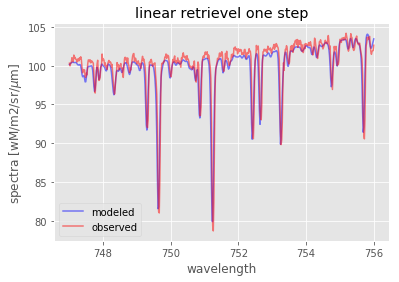

In [2165]:
plt.plot(mySetup.wl_out,F_forward,label='modeled',color='b',alpha=0.5)
plt.plot(mySetup.wl_out,spectra,label='observed',color='r',alpha=0.5)
plt.legend()
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('linear retrievel one step')

Text(0.5,1,'F_forward-F_observed')

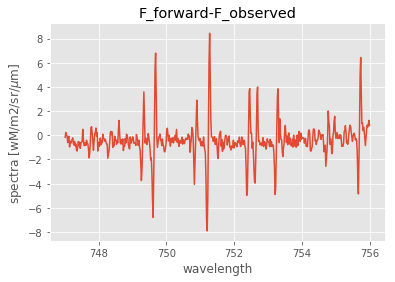

In [2166]:
plt.plot(mySetup.wl_out,F_forward-spectra)
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('F_forward-F_observed')

In [2167]:
ma,mb,mc = iterate_fit([0,1,40,0.07,4]+[0.2,1.6,310,2.8],mySetup,spectra,n_itr=200,thrs=1e-10)

[0, 0, 0, 0.07, 0, 0, 0, 0, 1.2484061884071878]
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
(9,)
iteration 17


In [2168]:
len(ma)

18

In [2169]:

np.array(ma)[:-1]

array([[1.86488603e-06, 1.01174709e+00, 3.20715805e+01, 7.00041729e-02,
        3.99939807e+00, 1.65625777e-01, 1.35679330e+00, 3.15557004e+02,
        1.40649966e+00],
       [5.26533239e-06, 1.00170122e+00, 2.77336302e+01, 6.89614745e-02,
        3.99940332e+00, 1.10106125e-01, 1.23027089e+00, 3.16502990e+02,
        1.26813818e+00],
       [2.75998478e-06, 9.99917544e-01, 2.81860590e+01, 7.04222549e-02,
        3.99940492e+00, 1.10189946e-01, 1.22925166e+00, 3.16843361e+02,
        1.15691498e+00],
       [3.77606777e-07, 9.99211925e-01, 2.93295428e+01, 7.09491853e-02,
        3.99940325e+00, 1.21204679e-01, 1.26047408e+00, 3.16668468e+02,
        1.20131369e+00],
       [1.06975897e-07, 9.99387487e-01, 2.95853394e+01, 7.08847170e-02,
        3.99939971e+00, 1.21920817e-01, 1.26717903e+00, 3.16524985e+02,
        1.24798370e+00],
       [1.39266501e-07, 9.99370592e-01, 2.95590470e+01, 7.08784843e-02,
        3.99939610e+00, 1.21899538e-01, 1.26717349e+00, 3.16521261e+02,
        1.2

In [2170]:

np.array(ma)[:,3]

array([0.07000417, 0.06896147, 0.07042225, 0.07094919, 0.07088472,
       0.07087848, 0.07087945, 0.07087928, 0.07087921, 0.07087926,
       0.07087926, 0.07087927, 0.07087926, 0.07087926, 0.07087926,
       0.07087927, 0.07087927, 0.07087927])

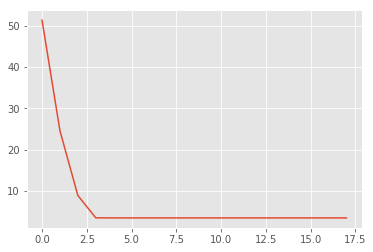

In [2171]:
plt.plot(mc)

In [2172]:
ma

[array([1.86488603e-06, 1.01174709e+00, 3.20715805e+01, 7.00041729e-02,
        3.99939807e+00, 1.65625777e-01, 1.35679330e+00, 3.15557004e+02,
        1.40649966e+00]),
 array([5.26533239e-06, 1.00170122e+00, 2.77336302e+01, 6.89614745e-02,
        3.99940332e+00, 1.10106125e-01, 1.23027089e+00, 3.16502990e+02,
        1.26813818e+00]),
 array([2.75998478e-06, 9.99917544e-01, 2.81860590e+01, 7.04222549e-02,
        3.99940492e+00, 1.10189946e-01, 1.22925166e+00, 3.16843361e+02,
        1.15691498e+00]),
 array([3.77606777e-07, 9.99211925e-01, 2.93295428e+01, 7.09491853e-02,
        3.99940325e+00, 1.21204679e-01, 1.26047408e+00, 3.16668468e+02,
        1.20131369e+00]),
 array([1.06975897e-07, 9.99387487e-01, 2.95853394e+01, 7.08847170e-02,
        3.99939971e+00, 1.21920817e-01, 1.26717903e+00, 3.16524985e+02,
        1.24798370e+00]),
 array([1.39266501e-07, 9.99370592e-01, 2.95590470e+01, 7.08784843e-02,
        3.99939610e+00, 1.21899538e-01, 1.26717349e+00, 3.16521261e+02,
      

In [2173]:
F_forward,K = forward_model_shift(np.array(ma)[-1,:],mySetup,compK=True)

Text(0.5,1,'non-linear retrievel last step')

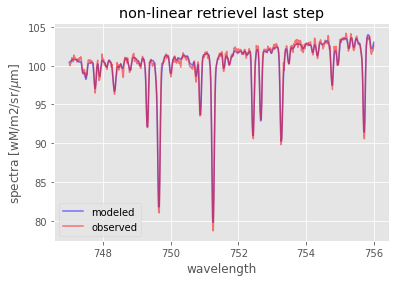

In [2174]:

plt.plot(mySetup.wl_out,F_forward,label='modeled',color='b',alpha=0.5)
plt.plot(mySetup.wl_out,spectra,label='observed',color='r',alpha=0.5)
plt.legend()
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('non-linear retrievel last step')

Text(0.5,1,'F_forward-F_observed')

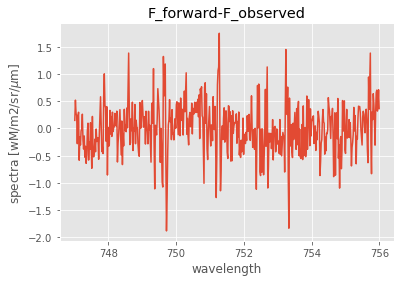

In [2175]:
plt.plot(mySetup.wl_out,F_forward-spectra)
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('F_forward-F_observed')

In [2073]:
spectra2 =spectra_[220,:,550]
F_forward,K = forward_model_shift([0,1,40,0.07]+[0.132,0.38,233.1,0],mySetup,compK=True)
x_linear,sif_1sigma,chi2_r = linear_fit(spectra2)
#add prior info
xa =[0,0,0,0.07]+list(x_linear[4:]) #[0,0,0,0,0,0,10]
invSa = np.zeros((len(xa),len(xa)))
invSa[3,3] = 1/(0.001**2)
invSa[-1,-1] = 1/(1**2)

Text(0.5,1,'non-linear retrievel last step')

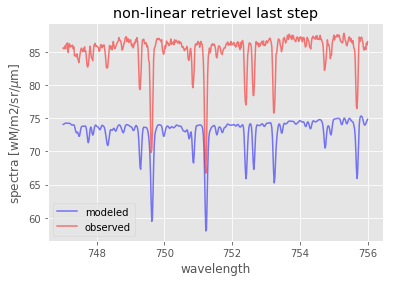

In [1499]:
plt.plot(mySetup.wl_out,F_forward,label='modeled',color='b',alpha=0.5)
plt.plot(mySetup.wl_out,spectra2,label='observed',color='r',alpha=0.5)
plt.legend()
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('non-linear retrievel last step')

Text(0.5,1,'F_forward-F_observed')

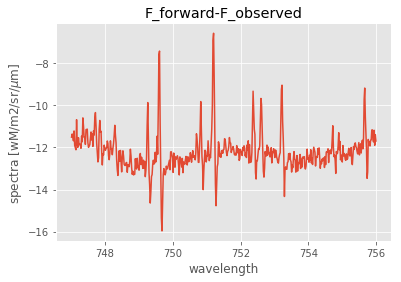

In [1500]:
plt.plot(mySetup.wl_out,F_forward-spectra2)
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('F_forward-F_observed')

In [1501]:

ma,mb,mc =iterate_fit([0,1,40,0.07]+[0.132,0.38,233.1,0],mySetup,spectra2,n_itr=200,thrs=1e-10)

[0, 0, 0, 0.07, 0.03179848714735678, 0.5463863328779459, 268.0266493695314, 1.5966216966664213]
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)

In [1502]:
F_forward,K = forward_model_shift(np.array(ma)[-1,:],mySetup,compK=True)

In [1503]:
ma

[array([ 1.41204278e-07,  9.98677066e-01,  4.54576280e+01,  6.94937943e-02,
         2.53420634e-02,  2.52016777e-01,  2.76467935e+02, -1.17581108e+00]),
 array([ 1.21869747e-07,  9.98688198e-01,  4.56038832e+01,  6.88508912e-02,
         2.45788878e-02,  2.17200660e-01,  2.77465182e+02, -1.50345808e+00]),
 array([ 1.21967005e-07,  9.98689315e-01,  4.55938900e+01,  6.88547512e-02,
         2.45667804e-02,  2.16651580e-01,  2.77481191e+02, -1.50871855e+00]),
 array([ 1.22158176e-07,  9.98688917e-01,  4.55943116e+01,  6.88546179e-02,
         2.45669661e-02,  2.16653000e-01,  2.77481117e+02, -1.50869378e+00]),
 array([ 1.22243461e-07,  9.98688998e-01,  4.55939705e+01,  6.88546229e-02,
         2.45668369e-02,  2.16653518e-01,  2.77481104e+02, -1.50868913e+00]),
 array([ 1.22090924e-07,  9.98689064e-01,  4.55943512e+01,  6.88546502e-02,
         2.45670062e-02,  2.16659107e-01,  2.77480949e+02, -1.50863860e+00]),
 array([ 1.22247850e-07,  9.98688987e-01,  4.55939674e+01,  6.88546182e-02,


In [1504]:
np.array(ma)[:,-1]

array([-1.17581108, -1.50345808, -1.50871855, -1.50869378, -1.50868913,
       -1.5086386 , -1.50870148, -1.50863777, -1.50870165, -1.50863773,
       -1.50870166, -1.50863772, -1.50870166, -1.50863773, -1.50870166,
       -1.50863772, -1.50870167, -1.50863772, -1.50870167, -1.50863773,
       -1.50870167, -1.50863772, -1.50870166, -1.50863772, -1.50870166,
       -1.50863773, -1.50870166, -1.50863773, -1.50870166, -1.50863772,
       -1.50870166, -1.50863773, -1.50870166, -1.50863773, -1.50870166,
       -1.50863773, -1.50870166, -1.50863773, -1.50870167, -1.50863773,
       -1.50870166, -1.50863772, -1.50870167, -1.50863773, -1.50870167,
       -1.50863772, -1.50870166, -1.50863772, -1.50870166, -1.50863773,
       -1.50870166, -1.50863772, -1.50870167, -1.50863773, -1.50870166,
       -1.50863773, -1.50870166, -1.50863772, -1.50870167, -1.50863773,
       -1.50870166, -1.50863772, -1.50870167, -1.50863772, -1.50870166,
       -1.50863773, -1.50870166, -1.50863773, -1.50870166, -1.50

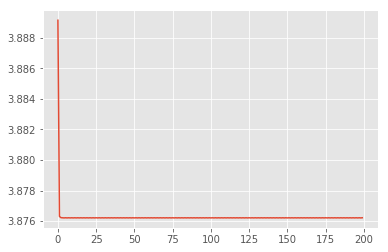

In [1505]:
plt.plot(mc)

Text(0.5,1,'spectra 2 non-linear retrievel last step')

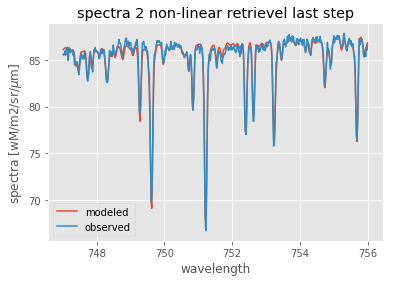

In [1506]:

plt.plot(mySetup.wl_out,F_forward,label='modeled')
plt.plot(mySetup.wl_out,spectra2,label='observed')
plt.legend()
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('spectra 2 non-linear retrievel last step')

Text(0.5,1,'spectra 2 F_forward-F_observed')

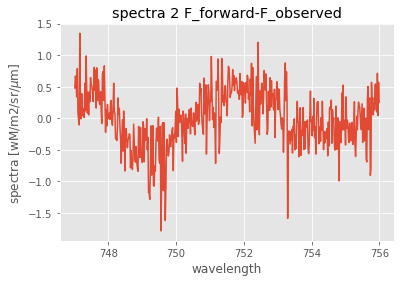

In [1507]:
plt.plot(mySetup.wl_out,F_forward-spectra2)
plt.xlabel('wavelength')
plt.ylabel(r'spectra [wM/m2/sr/$\mu $m]')
plt.title('spectra 2 F_forward-F_observed')

In [1508]:
np.array(ma)[:,-1]

array([-1.17581108, -1.50345808, -1.50871855, -1.50869378, -1.50868913,
       -1.5086386 , -1.50870148, -1.50863777, -1.50870165, -1.50863773,
       -1.50870166, -1.50863772, -1.50870166, -1.50863773, -1.50870166,
       -1.50863772, -1.50870167, -1.50863772, -1.50870167, -1.50863773,
       -1.50870167, -1.50863772, -1.50870166, -1.50863772, -1.50870166,
       -1.50863773, -1.50870166, -1.50863773, -1.50870166, -1.50863772,
       -1.50870166, -1.50863773, -1.50870166, -1.50863773, -1.50870166,
       -1.50863773, -1.50870166, -1.50863773, -1.50870167, -1.50863773,
       -1.50870166, -1.50863772, -1.50870167, -1.50863773, -1.50870167,
       -1.50863772, -1.50870166, -1.50863772, -1.50870166, -1.50863773,
       -1.50870166, -1.50863772, -1.50870167, -1.50863773, -1.50870166,
       -1.50863773, -1.50870166, -1.50863772, -1.50870167, -1.50863773,
       -1.50870166, -1.50863772, -1.50870167, -1.50863772, -1.50870166,
       -1.50863773, -1.50870166, -1.50863773, -1.50870166, -1.50

In [1512]:

SIF = []; SIF_1SIGMA = [];CHI2_R = []
for i in range(100,102):
    for j in range(10,20):
        spectra = spectra_[i,:,j]
        _,K = forward_model_shift([0,1,40,0.07]+[0.132,0.38,233.1,0],mySetup,compK=True)
        x_linear,sif_1sigma,chi2_r = linear_fit(spectra)
        #add prior info
        xa =[0,0,0,0.07,0,0,0,x_linear[-1]]#+list(x_linear[4:]) #[0,0,0,0,0,0,10]
        invSa = np.zeros((len(xa),len(xa)))
        invSa[-1,-1] = 1/(0.1**2)
        invSa[3,3] = 1/(0.008**2)
        ma,mb,mc =iterate_fit([0,1,40,0.07]+[0.132,0.38,233.1,0],mySetup,spectra,n_itr=200,thrs=1e-10)
        SIF.append(ma[-1][-1])
        SIF_1SIGMA.append(mb[-1])
        CHI2_R.append(mc[-1])
        

[0, 0, 0, 0.07, 0, 0, 0, 0.5633346601395957]
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)


RuntimeError: no filter weights given

In [110]:
SIF = np.reshape(np.array(SIF),(2,10))

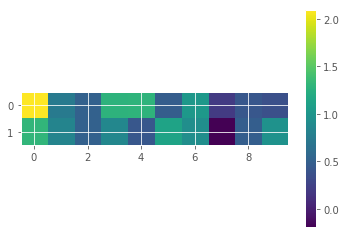

In [111]:
plt.imshow(np.array(SIF))
plt.colorbar()

In [108]:
SIF

array([[1.11705576, 0.5830816 , 0.60389113, 1.15996298, 1.02729951,
        0.55275171, 0.79666046, 0.39140188, 0.5566552 , 0.50727497],
       [0.7752244 , 0.65195165, 0.81342446, 0.99977152, 0.64872309,
        0.99044986, 0.86398036, 0.22664276, 0.69554782, 0.97136556]])

In [112]:
SIF

array([[ 2.09268259,  0.75080587,  0.51744511,  1.28318748,  1.29728309,
         0.47797077,  1.02917044,  0.20267548,  0.42839246,  0.36556143],
       [ 1.31247678,  0.84255759,  0.51732899,  0.86189353,  0.42641457,
         1.13372404,  0.93544833, -0.19239609,  0.48807547,  0.97136556]])

In [ ]:
nump